# Homework 5 - The Marvel Universe!

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## 1. Data

### Preprocessing

In [3]:
nodes = pd.read_csv('nodes.csv')

In [4]:
edges = pd.read_csv('edges.csv')

In [5]:
hero = pd.read_csv('hero-network.csv')

Take a look

In [6]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [7]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [8]:
hero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


We will not have to deal with NA values, now let's see in what format are the names/words written

In [8]:
nodes.head(10)

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
5,4-D MAN/MERCURIO,hero
6,8-BALL/,hero
7,A '00,comic
8,A '01,comic
9,A 100,comic


In [9]:
#Count number of distinct elements in specified axis
nodes.nunique()

node    19090
type        2
dtype: int64

In [10]:
edges.head(10)

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
5,3-D MAN/CHARLES CHAN,H2 252
6,3-D MAN/CHARLES CHAN,M/PRM 35
7,3-D MAN/CHARLES CHAN,M/PRM 36
8,3-D MAN/CHARLES CHAN,M/PRM 37
9,3-D MAN/CHARLES CHAN,WI? 9


In [51]:
edges.nunique()

hero      6439
comic    12651
dtype: int64

In [52]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [53]:
hero.nunique()

hero1    6211
hero2    6173
dtype: int64

##### Problems:
 - Some heroes' names in 'hero-network.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'
 - Some heroes' names in 'hero-network.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'
 - The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'
 - Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.

First of all, we remove the extra characters from the neroes' names.

In [6]:
hero["hero1"] = hero["hero1"].str.rstrip('/ ')
hero["hero2"] = hero["hero2"].str.rstrip('/ ')

In [7]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [8]:
hero.nunique()

hero1    6206
hero2    6169
dtype: int64

We have less unique values after the rstrip, so there were actually some names that were the same but with extra characters.

Now let's change Spiderman's name in the hero dataframe to the complete 'SPIDER-MAN/PETER PARKER'.

In [9]:
hero[hero["hero1"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'
hero[hero["hero2"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'

In [10]:
print(hero[hero["hero1"]=='SPIDER-MAN/PETER PAR'].shape)
print(hero[hero["hero2"]=='SPIDER-MAN/PETER PAR'].shape)

(0, 2)
(0, 2)


Done! No more short name for Spiderman.

What we need to do now is deleting the rows of the file csv in hero-network where hero1 == hero2. The best thing to do is by using the pandas dataframe hero.

In [11]:
hero = hero[hero['hero1']!= hero['hero2']]
hero.reset_index(drop = True, inplace = True)

In [12]:
#show there are no more rows where hero1 = hero2
hero[hero['hero1'] == hero['hero2']].count()

hero1    0
hero2    0
dtype: int64

### Graphs setup

**First graph**: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

First of all, we need to define a metric to calculate the weights so that the heroes with more collaborations has a lower 'cost'. In order to match the number of collaborations with an appropriate weight, we can use the inverse of the normalized number of collaborations for each hero. Just applying (max - X) / (max - min) to each value, we will obtain a 'cost' scaled between 0 and 1, meaning that if a collaboration has a weight close to 0 it is much more important than a collaboration with a weight close to 1.

We create a column with the number of collaboration for each pair of heroes.

In [13]:
hero['number of coll'] = hero.groupby(['hero1', 'hero2'])['hero1'].transform('count')

In [14]:
hero

,hero1,hero2,number of coll
0,"LITTLE, ABNER",PRINCESS ZANDA,5
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4
3,"LITTLE, ABNER",PRINCESS ZANDA,5
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
...,...,...,...
558513,COLOSSUS II/PETER RA,CALLISTO,15
558514,CALLISTO,ROGUE,10
558515,CALLISTO,CALIBAN,5
558516,CALIBAN,ROGUE,6


We will use it only to compute the normalization, then we will delete it.

In [18]:
MAX = hero['number of coll'].max()

In [19]:
MIN = hero['number of coll'].min()

In [20]:
print(MAX)
print(MIN)

1267
1


In [21]:
#we compute the weight: it will increase where the number of collaborations is lower
hero['weight'] = (MAX - hero['number of coll'])/(MAX - MIN)

In [22]:
hero.head(15)

,hero1,hero2,number of coll,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,5,0.99684
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.99763
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.99763
3,"LITTLE, ABNER",PRINCESS ZANDA,5,0.99684
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.99763
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.99763
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC",2,0.99921
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA",1,1.00000
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK,1,1.00000
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.,1,1.00000


In [23]:
hero = hero.drop('number of coll', axis=1)

In [24]:
hero

,hero1,hero2,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,0.996840
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.997630
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,0.997630
3,"LITTLE, ABNER",PRINCESS ZANDA,0.996840
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.997630
...,...,...,...
558513,COLOSSUS II/PETER RA,CALLISTO,0.988942
558514,CALLISTO,ROGUE,0.992891
558515,CALLISTO,CALIBAN,0.996840
558516,CALIBAN,ROGUE,0.996051


Now we will use the NetworkX package and functions to create our graph.

In [25]:
graph1 = nx.from_pandas_edgelist(hero, 'hero1', 'hero2', edge_attr='weight')

In [ ]:
nx.draw(graph1)

**Second graph**: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

In [26]:
graph2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')

In [27]:
graph2.add_nodes_from(nodes['node'], type=nodes['type'])

### Functionality 2 - Find top Superheroes

#### Backend implementation

We have to implement a function computing, given a graph, for each node, the given centrality measure. Similarly to the others functionality, it will be possible to select a number N of superheroes to consider (topN heroes: top N heroes to have appeared in the most number of comics). 
We define a function for finding the best (N) superheroes.

In [28]:
#keep only a portion of the graph according to the number of comics a superhero appeared in 
#the csv file to take into account is edges.csv
#it is better to delete nodes from the graph taken as parameter instead of dropping rows from the csv file, since we want to use
#this function in the find_centrality function we will define below 
def topN_comics(graph, N = None): #Note: Whenthe value of N is not set, the function should coonsider the whole data
    if N != None: 
        N_nodes = edges.groupby('hero', as_index= False).count().sort_values('comic', ascending=False).head(N+1)
        list_nodes = list(N_nodes['hero'])
        if nx.is_weighted(graph):
            graph = graph.subgraph(list_nodes)
        else: 
            N_edges = edges[edges['hero'].isin(N_nodes['hero'])] #we want to keep both the heroes and the comics node 
            edge_list = list(N_edges.itertuples(index=False, name = None))
            graph = graph.edge_subgraph(edge_list) 
               
    return graph



In [63]:
#Backend function for finding the centrality measure

def find_centrality(graph, node, centrality_metric, N = None): 
    graph = topN_comics(graph, N)   #eventually obtain a portion of the graph
    
    if centrality_metric == 'Closeness Centrality':
        print('The centrality you have chosen computes centrality based on the the closeness (consider the shortest path) of a node with respect to the all the others reachable from it')
        if nx.is_weighted(graph):  #graph 1
            centrality_measure = nx.closeness_centrality(graph, distance = 'weight')
            node_centrality = nx.closeness_centrality(graph,node, distance = 'weight')
            if node_centrality >= 0.5: 
                print('%s centrality:' %node, node_centrality)
                print("The value of closeness centrality of the given node %s is high. This means that from that node many other nodes can be reached. In practice, for our particular case, this means that the superhero of interest is connected to many other heroes in the network in the sense that he/she appears in many comics with other superheroes and, if it doesn't, it is 'close' in the network with many others  " %node)
            else: 
                print('%s centrality:' %node, node_centrality)
                print("The value of closeness centrality for the given node %s is low. The superhero in the nework is quite far from others in the network" %node)
        else:                  #graph 2
            centrality_measure = nx.closeness_centrality(graph)
            node_centrality = nx.closeness_centrality(graph,node)
            print('%s centrality:' %node, node_centrality)
            if node_centrality >= 0.5: 
                print("the value of closeness centrality of the given node %s is high. This means that from that node many other nodes can be reached. In practice, for our particular case, this means that the superhero/comic of interest is related (directly or indirectly) to many comics/superheroes  " %node)
            else: 
                print("The value of closeness centrality for the given node %s is low. The superhero in the nework is quite far from others in the network" %node)

    
    
    elif centrality_metric == 'Betweenness Centrality':
        print('The centrality you have chosen computes centrality based on the paths that lead a node to another, passing trough the node of interest ')
        if nx.is_weighted(graph):
            centrality_measure = nx.betweenness_centrality(graph, weight = 'weight')
            node_centrality = centrality_measure[node] 
            print('%s centrality:' %node, node_centrality)

            if node_centrality >= 0.5: 
                print("The value of betwenness centrality of the given node %s is high. This means that from that node many other nodes can be reached in few steps. In practice, for our particular case, this means that the superhero of interest is connected to many other heroes in the network in the sense that he/she appears in many comics with other superheroes and, if it doesn't, it is 'close' in the network with many others  " %node)
            else: 
                print("The value of betweenness centrality for the given node %s is low. The superhero in the network does not represent a crossroad for many paths in the network" %node)
        else:
            centrality_measure = nx.betweenness_centrality(graph)
            node_centrality =centrality_measure[node] 
            print('%s centrality:' %node, node_centrality)  

            if node_centrality >= 0.5: 
                
                print("The value of betweenness centrality for the given node %s is high. This means that the comic/hero in the network is either a comic not only connected to many heroes, but also that these related heroes are in turn connected to many comics" %node)
            else: 
                print("The value of betweenness centrality for the given node %s is low. This means that the the comic/hero does not appear in the shortest paths of the network connected any two nodes" %node)


    elif centrality_metric == 'PageRank Centrality':
        print('The centrality you have chosen computes centrality based on the structure of the (incoming) links')
        if nx.is_weighted(graph):
            centrality_measure = nx.pagerank(graph,alpha = 0.9, weight = 'weight')
            node_centrality = centrality_measure[node]
        else:
            centrality_measure = nx.pagerank(graph,alpha = 0.9)
            node_centrality = centrality_measure[node]   
        print('%s centrality:' %node, node_centrality)
        if node_centrality >= 0.5:
            print("The value of PageRank centrality for the given node %s is high. This means that not only that the node has many links in the network, but also that the connected node are in turn pointed to many others " %node)
        else: 
            print("The value of PageRank centrality for the given node %s is low. >This means that the node of interest is not pointed to many 'relevant' nodes. " %node)


    elif centrality_metric == 'Degree Centrality':
        print('The centrality you have chosen computes centrality based on the degree of the nodes.The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G')
        centrality_measure = nx.degree_centrality(graph)
        node_centrality = centrality_measure[node]
        print('%s centrality:' %node, node_centrality)   
        if node_centrality >= 0.5: 
            print("The value of degree centrality for the node %s is high: it is connected to many other nodes" %node)
        else: 
            print("The value of degree centrality for the node %s is low: it is NOT connected to many other nodes" %node)
    return centrality_measure, node_centrality 

*Note on PageRank centrality* :
 
 The PageRank is defined for directed graphs, but in some special cases applications for undirected graphs occur. In the literature it is widely noted that the PageRank for undirected graphs are **proportional to the degrees of the vertices of the graph**. The PageRank algorithm of networkx was designed for directed graphs but this algorithm does not check if the input graph is directed and will execute on undirected graphs by converting each edge in the directed graph to two edges. 

In [67]:
#test the function with the first graph 
graph_measure1, node_centrality1= find_centrality(graph1, 'CAPTAIN AMERICA', 'Degree Centrality', 18)

The centrality you have chosen computes centrality based on the degree of the nodes.The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G
CAPTAIN AMERICA centrality: 1.0
The value of degree centrality for the node CAPTAIN AMERICA is high: it is connected to many other nodes


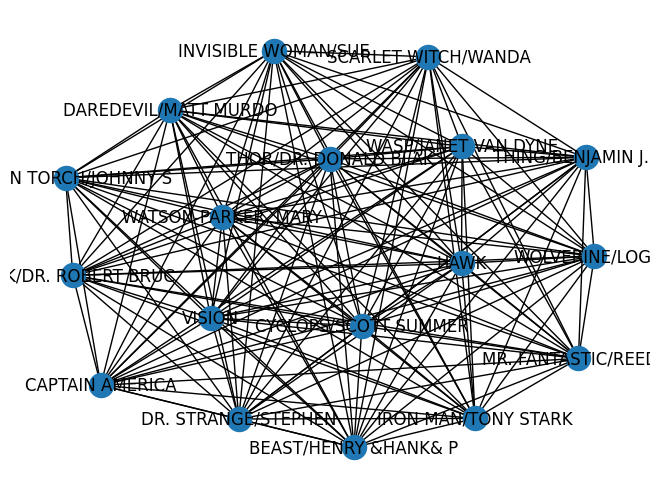

In [68]:
nx.draw(topN_comics(graph1, 18), with_labels = True)

In [27]:
graph_measure1

{'BLACK KNIGHT V/DANE': 0.9389524343211264,
 'HAWK': 0.954943176103792,
 'POLARIS/LORNA DANE': 0.8060043575450607,
 'IRON MAN/TONY STARK': 1.0154718191864818,
 'CAPTAIN MARVEL II/MO': 0.8710742790740342,
 'CRYSTAL [INHUMAN]': 0.9036617573580149,
 'JONES, RICHARD MILHO': 0.8932337192985205,
 'PARKER, MAY': 0.7674225943113472,
 'LEEDS, BETTY BRANT': 0.709650095292667,
 'SCARLET WITCH/WANDA': 1.0040801219630413,
 'SUMMERS, NATHAN CHRI': 0.8237777809910779,
 'SHADOWCAT/KATHERINE': 0.8377448385389089,
 'BALDER [ASGARDIAN]': 0.7884193555083484,
 'WONDER MAN/SIMON WIL': 0.985998373111338,
 'CANNONBALL II/SAM GU': 0.848020244120274,
 'PSYLOCKE/ELISABETH B': 0.8286545454545451,
 'LOKI [ASGARDIAN]': 0.8403398530843432,
 'BEAST/HENRY &HANK& P': 1.0018640967923467,
 'CAPTAIN AMERICA': 1.032364453464772,
 'USAGENT/CAPTAIN JOHN': 0.8177707600660301,
 'CLEA': 0.6864641133623727,
 'BOOMER/TABITHA SMITH': 0.7455147414842246,
 'MAGNETO/MAGNUS/ERIC': 0.8563376047499153,
 'NIGHTCRAWLER/KURT WA': 0.9282961

In [28]:
node_centrality1

1.032364453464772

In [32]:
#test the function with the second graph (Closeness and betweenness centrality measure takes at least 3 min for the second graph to be computed)
graph_measure2, node_centrality2 = find_centrality(graph2, 'CA 312', 'Closeness Centrality', 9)

The centrality you have chosen computes centrality based on the the closeness (consider the shortest path) of a node with respect to the all the others reachable from it
CA 312 centrality: 0.2810615199034982
The value of closeness centrality for the given node CA 312 is low. The superhero in the nework is quite far from others in the network


In [33]:
graph_measure2

{'S-M 76': 0.28754509208277956,
 'ASM 86': 0.28754509208277956,
 'ASM 342': 0.28754509208277956,
 'WOSM 37': 0.28754509208277956,
 'H2 219': 0.2686236253990777,
 'T 348': 0.2715374271627073,
 'M/TU 66': 0.28754509208277956,
 'FF 398': 0.27705112960760997,
 'DEF 115': 0.2686236253990777,
 'INV 33': 0.29696078431372547,
 'M/TIO 28': 0.278656853725851,
 'A 290': 0.2810615199034982,
 'UX 4': 0.2682430038965639,
 'FF 246': 0.278656853725851,
 'S-M 54': 0.28754509208277956,
 'M/TU 110': 0.3195821903355138,
 'PPTSS 108': 0.28754509208277956,
 'T2 32': 0.2715374271627073,
 'ASM2 32': 0.28754509208277956,
 'FF 292': 0.2744653860094237,
 'DAMCON 2': 0.2757396449704142,
 'T 484': 0.2715374271627073,
 'FF 282': 0.2744653860094237,
 'H2 438': 0.2686236253990777,
 'IM 15/1': 0.2763433993248791,
 "W '00": 0.2682430038965639,
 'M/CP 52': 0.2682430038965639,
 'CM 47': 0.26984409799554565,
 'M/CP 52/4': 0.2686236253990777,
 "T '00": 0.2715374271627073,
 'AI 4': 0.2715374271627073,
 'PPTSS 23': 0.2875450

In [32]:
node_centrality2

0.2810615199034982

#### Frontend implementation

Now, what we want is a table containing a summary of the centrallity measure given by the user. in particular, the information provided to the user should be: 
- the average of the requested centrality measure for ALL the network's NODES
- The requested centrality measure's value for the given node

In [47]:
#ask the user the query

metric = input("Please, select a metric: ")
nodee = input("Please, choose a node: ")
Y_N = input("Do you want to select only N top superheroes? (Y/N)")
if Y_N == 'Y': 
    N = input('N = ')
else : 
    N = None
centrality_data = pd.DataFrame({'Average_value' : [], 'Node_centrality' : []})
G_measure, N_measure = find_centrality(graph1, nodee, metric, N)

The* centrality you have chosen computes centrality based on the structure of the incoming links


In [54]:
#compute average score and fill the table
scores = list(G_measure.values())
avg_score = sum(scores)/len(scores)
centrality_data.loc[0, 'Average_value']= avg_score
centrality_data.loc[0, 'Node_centrality'] = N_measure

In [55]:
#print the table
centrality_data

,Average_value,Node_centrality
0,0.000156,0.005324
